# U-Net for Image Classification

# Project Overview

This project explores the implementation and application of the U-Net architecture, initially developed for image segmentation tasks. Our objective is to first apply U-Net to segment images effectively in various datasets, such as medical and satellite imagery. Subsequently, we adapt the U-Net architecture for image classification by modifying its network structure. The goal is to demonstrate the versatility of U-Net in handling different types of deep learning tasks in computer vision, assessing its performance in both segmentation and classification scenarios.


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

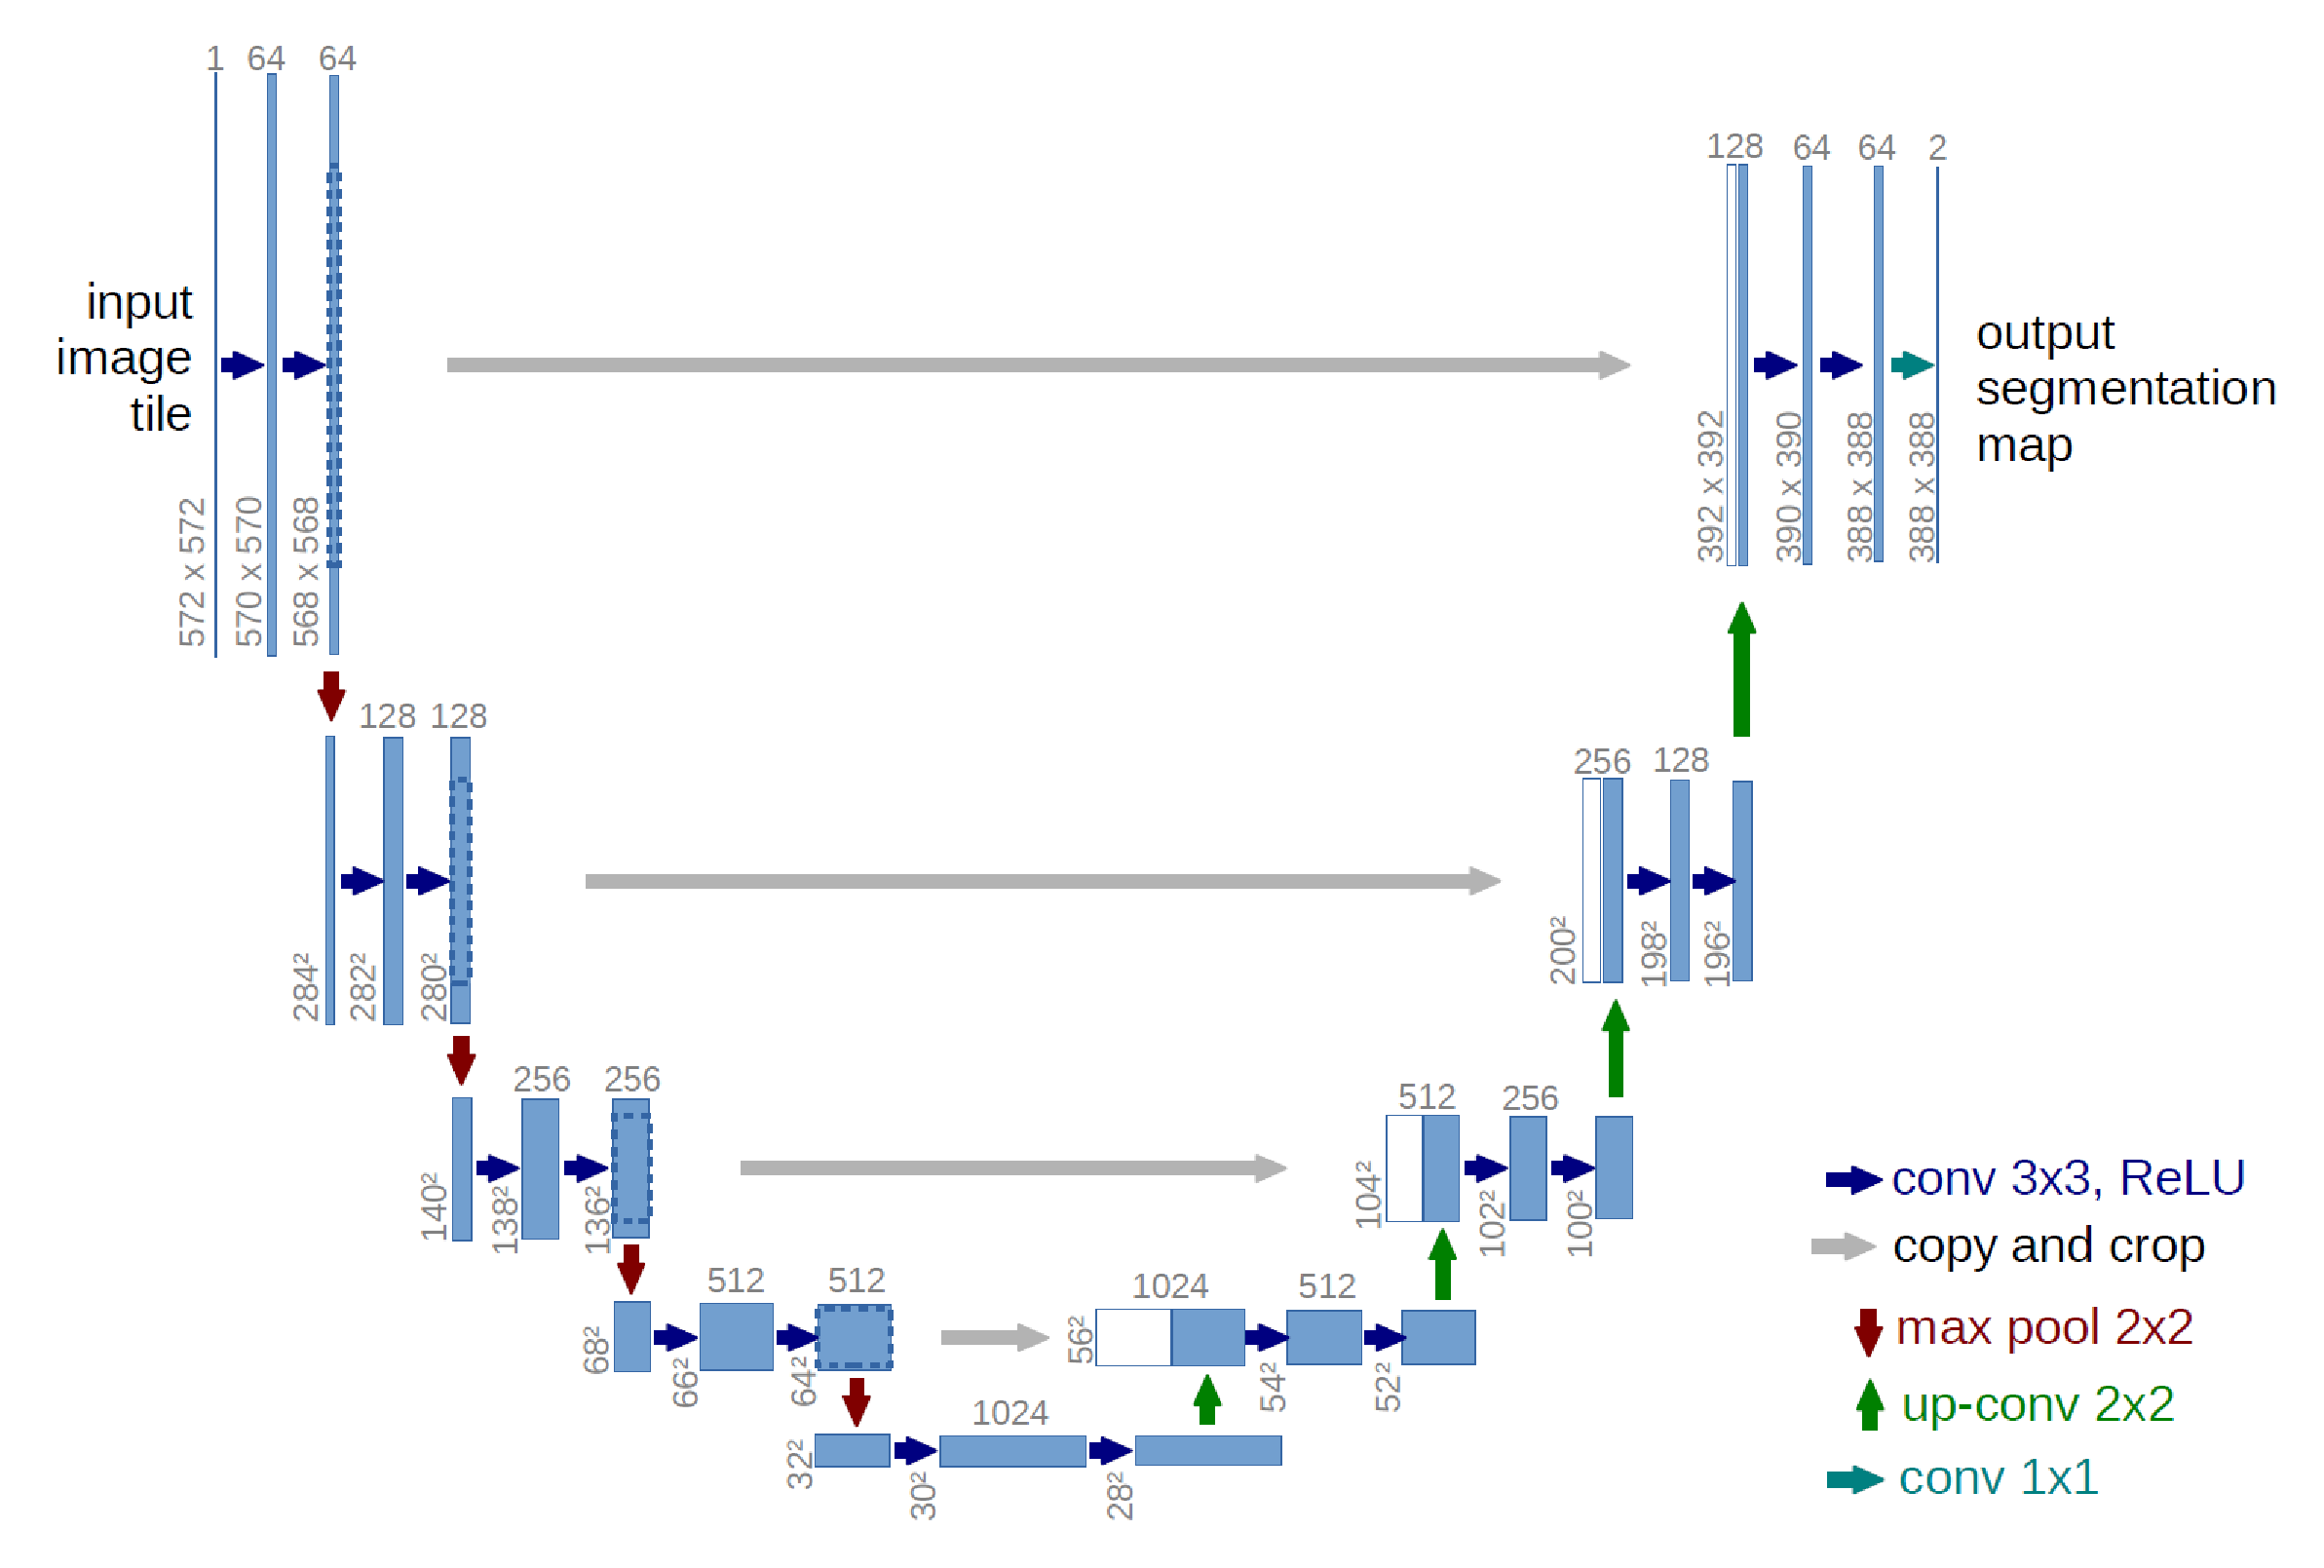

In [40]:
# Specify the path to your image file
image_path = 'UNET_architecture.png'

# Load the image using matplotlib's imread function
img = mpimg.imread(image_path)

# Create a larger figure with higher DPI
plt.figure(figsize=(10, 8), dpi=300)

plt.imshow(img, interpolation='nearest')
plt.axis('off')
plt.show()

## 2. Build U-Net Architecture

The U-Net model is constructed using PyTorch, featuring an encoder-decoder structure with skip connections. Key components include:

- **Encoder (Downsampling Path):** Sequential convolutional blocks reduce the spatial dimensions while increasing the feature depth.
- **Bottleneck:** The lowest resolution is processed here, allowing the network to learn the most abstract features.
- **Decoder (Upsampling Path):** Transposed convolutions are used to increase spatial dimensions, paired with skip connections from the encoder to preserve high-resolution details.
- **Final Layer:** The output of the last upsampling step is passed through a convolutional layer to map the deep feature maps to the desired output channels.

In [3]:
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # Same conv
            nn.BatchNorm2d(out_channels), # NOT IN THE PAPER! (batch norm paper came out after U-Net, but it can only make it better:)
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        return self.conv(x)

In [37]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Bottleneck                     
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Final layer 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2): # Up & DoubleConv is a single step. That is why we are using a step of 2
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:# reshape
                x = TF.resize(x, size=skip_connection.shape[2:]) # only need height and the width
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


One problem that could occur:
Lets say the input layer is 161x161. The max pool will going to floor the div by 2 and create an 80x80. Then, during the up sample it will create an output of 160x160. This means we won't be able to concatenate the two. 

To solve this, always choose an input that is divisible by 16. 

In [41]:
def check_size():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

if __name__ == "__main__":
    check_size()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


## 2. Try Image Segmentation

Using the U-Net model, perform image segmentation on a dataset. The process involves three main steps:

### Dataset Preparation

- **Objective:** Load and preprocess the dataset suitable for segmentation tasks.
- **Details:** Choose datasets that are commonly used for segmentation tasks, such as medical images (e.g., MRI or CT scans) or satellite images. 
- **Preprocessing Steps:** Include normalization, resizing images to a consistent dimension, and possibly augmenting the dataset to improve model robustness.

### Training

- **Objective:** Train the U-Net model on the prepared dataset.
- **Loss Function:** Use an appropriate loss function for segmentation. Common choices include:
  - **Dice Loss:** Useful for dealing with class imbalance in images.
  - **Cross-Entropy Loss:** Standard loss for segmentation tasks.
- **Optimization:** Use optimizers like Adam or SGD to minimize the loss function.

### Evaluation

- **Objective:** Validate the model's performance on a separate test set.
- **Metrics:** Evaluate the model using segmentation-specific metrics such as:
  - **IoU (Intersection over Union):** Measures the overlap between the predicted segmentation and the ground truth.
  - **Dice Coefficient:** Similar to IoU, useful for assessing the quality of the segmentation.


In [39]:
import os 
from PIL import Image
from torch.utils.data import Dataset
import numpy as np 

In [42]:
class CarvanaDataset(Dataset):
    def __init__(self, iamge_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # Greyscale image
        
                                 
        

## 3. Modify the Code for Image Classification

To adapt the U-Net model for image classification tasks, follow these modifications:

### Adapt Network Structure

- **Objective:** Modify the U-Net model to output class probabilities.
- **Modifications:** 
  - Add a global average pooling layer after the last convolutional layer to reduce each feature map to a single number.
  - Append a fully connected layer (or layers) that outputs the probability for each class.

### Change Loss Function

- **Objective:** Utilize a suitable loss function for classification.
- **Loss Function:** For multi-class classification, use **Cross-Entropy Loss**, which is well-suited for discrete probability distributions.

### Output Adjustments

- **Objective:** Ensure the model outputs match the number of target classes.
- **Details:** 
  - Adjust the final layer to have as many outputs as there are classes.
  - Use a softmax activation function in the final layer to ensure the output values represent probabilities.